In [2]:
import torch 
import numpy as np
import pandas as pd
import scanpy as sc
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from scvi.distributions import NegativeBinomial

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import torch.nn.functional as F

import sys
# sys.path.insert(0, "/home/icb/alessandro.palma/environment/scportrait_ot/src")
sys.path.insert(0, "/nfs/homedirs/pala/scportrait_ot/src")

from dataloader import EmbeddingDecoderDataset
from decoding_modules import DecoderFromHarmony
from pathlib import Path

### Initialize dataset

In [3]:
dataset = EmbeddingDecoderDataset(adata_path="/nfs/homedirs/pala/scportrait_ot/project_folder/data/scrnaseq/sce_converted_processed_discovery_reduced.h5ad", 
                                     count_label=None, 
                                     embedding_label="HARMONY",
                                     batch_label="donor_id")

Initialize dataloaders

In [4]:
dataloader = torch.utils.data.DataLoader(dataset,
                                        batch_size=256,
                                        shuffle=True,
                                        num_workers=4)

/nfs/staff-ssd/pala/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Initialize model 

In [5]:
decoder_model = DecoderFromHarmony(input_dim=dataset.input_dim, 
                                   output_dim=dataset.output_dim,
                                   dims=[256, 256],
                                   batch_norm=False, 
                                   dropout=False,
                                   dropout_p=0.0, 
                                   batch_encoding=False, 
                                   batch_encoding_dim=None,
                                   learning_rate=1e-3
                                  )

In [6]:
decoder_model

DecoderFromHarmony(
  (decoder): MLP(
    (net): Sequential(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=256, out_features=37378, bias=True)
    )
  )
)

In [8]:
decoder_model.load_state_dict(torch.load("/nfs/homedirs/pala/scportrait_ot/project_folder/experiements/decoder_all/fearless-music-1/checkpoints/last.ckpt")["state_dict"])

<All keys matched successfully>

## Check reconstruction  

In [9]:
Xs = []
X_hat = []

with torch.no_grad():
    for batch in dataloader:
        Xs.append(batch["X"])
        size_factor = batch["X"].sum(1, keepdim=True)
        mu_hat = decoder_model.decoder(batch["X_emb"])
        mu_hat = F.softmax(mu_hat, dim=1)
        px = NegativeBinomial(mu=mu_hat * size_factor, theta=torch.exp(decoder_model.theta))
        X_hat.append(px.sample())

In [10]:
del dataloader
del dataset 

In [11]:
X_hat = torch.cat(X_hat, dim=0).cpu().detach().numpy()
Xs = torch.cat(Xs, dim=0).cpu().detach().numpy()
idx = torch.randint(0, X_hat.shape[0], (30000,))
X_hat = X_hat[idx]
Xs = Xs[idx]

In [12]:
obs = pd.DataFrame({"data_type": ["real" for _ in range(30000)]+["reconstructed" for _ in range(30000)]})

In [13]:
adata_generated = sc.AnnData(X=np.concatenate([Xs, X_hat]), 
                            obs=obs)

/nfs/staff-ssd/pala/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [14]:
sc.pp.log1p(adata_generated)
sc.tl.pca(adata_generated)
sc.pp.neighbors(adata_generated)
sc.tl.umap(adata_generated)

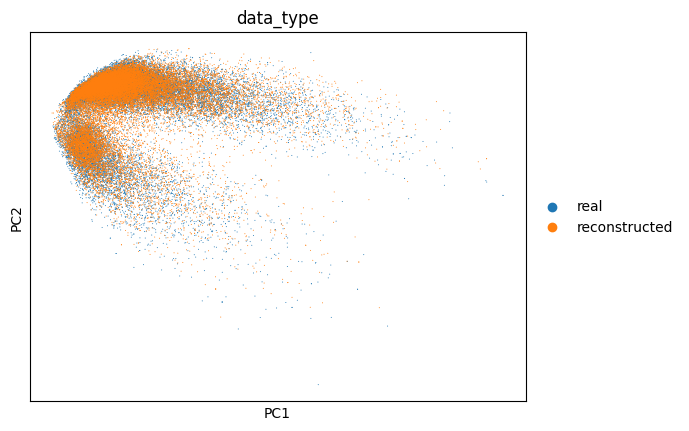

In [15]:
sc.pl.pca(adata_generated, color="data_type")

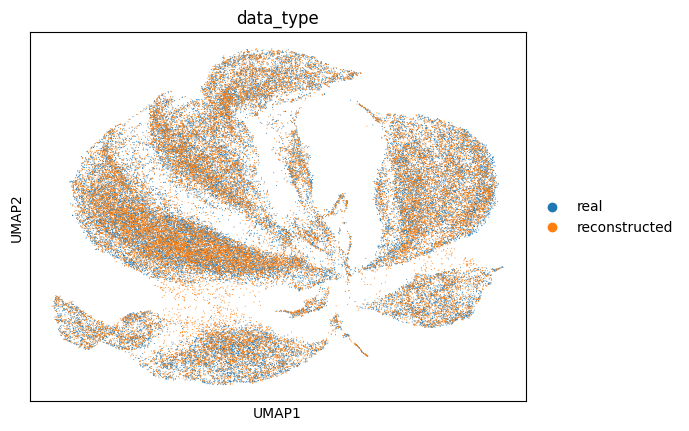

In [16]:
sc.pl.umap(adata_generated, color="data_type")